In [284]:
# Importation of liberies.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import copy
from scipy.interpolate import pchip_interpolate
from scipy.spatial.transform import Rotation as R
from scipy import interpolate, signal

In [285]:
# Functions
#_______________________________________________________________________________
def Load_Files(dir):
    data={}
    entries = os.listdir(dir)
    titles= ['Sensor','TimeStamp','Roll','Pitch','Yaw','xGyr','yGyr','zGyr',
             'BatteryLVL']
    for i in entries:
        if 'SENSOR'in i:
            name= i.split('.')
            s = pd.read_csv(dir + i, sep=",")
            s.columns= titles
            s['TimeStamp']= s['TimeStamp']/1000
            data[name[0]] = s
    return data
#_______________________________________________________________________________
def Plot_Data(data,test,phase):
  """
  This fuction plot the Roll, Pitch and Yaw data.
  """

  fig, ((ax1, axa), (ax2, axb), (ax3, axc)) = plt.subplots(3, 2, figsize=(9.6, 5.5))
  for i in data:
    s= data[i]
    ax1.plot(s['TimeStamp'],s['Roll'], label= i)
    ax2.plot(s['TimeStamp'],s['Pitch'], label= i)
    ax3.plot(s['TimeStamp'],s['Yaw'], label= i)
    axa.plot(s['TimeStamp'],s['xGyr'], label= i)
    axb.plot(s['TimeStamp'],s['yGyr'], label= i)
    axc.plot(s['TimeStamp'],s['zGyr'], label= i)
  fig.suptitle(phase+' '+test)
  ax1.set_xlabel('Time (s)')
  ax1.set_ylabel('Roll (°)')
  ax1.set_title('Roll')
  ax2.set_xlabel('Time (s)')
  ax2.set_ylabel('Pitch (°)')
  ax2.set_title('Pitch')
  ax3.set_xlabel('Time (s)')
  ax3.set_ylabel('Yaw (°)')
  ax3.set_title('Yaw')
  axa.set_xlabel('Time (s)')
  axa.set_ylabel('xGyr (°/s)')
  axa.set_title('xGyr')
  axb.set_xlabel('Time (s)')
  axb.set_ylabel('yGyr (°/s)')
  axb.set_title('yGyr')
  axc.set_xlabel('Time (s)')
  axc.set_ylabel('zGyr (°/s)')
  axc.set_title('zGyr')
  ax1.margins(0, 0.1)
  ax2.margins(0, 0.1)
  ax3.margins(0, 0.1)
  axa.margins(0, 0.1)
  axb.margins(0, 0.1)
  axc.margins(0, 0.1)
  axc.legend()
  fig.tight_layout()
  plt.show()
  return None
#_______________________________________________________________________________
def Set_Data(data):
  """
  This fuction set the sensors to start in 0.
  """
  for i in data:
    s= data[i]
    s= s.iloc[50:data[i].size-29,:]                                             #errase first 50 takes and last 29
    time= s["TimeStamp"]
    time= time-time.iloc[0]
    s['TimeStamp']= time
    data[i]= s
  return data 
#_______________________________________________________________________________
def Change_Range(data,thresh=89):
  """
  This fuction fix the angles lokking for the abrupt changes.
  """
  for s in data:
    n_d= data[s].loc[:,]
    for d in ['Roll','Pitch','Yaw']:
      var= n_d= data[s].loc[:,d]
      drv= np.where(((abs(var.diff()))>=thresh))
      drv=drv[0].tolist()
      if (len(drv) % 2) != 0: drv.append(len(n_d)-1)
      for f in range(0,len(drv),2):
        chg= var.iloc[drv[f]-1]+var.iloc[drv[f]]
        var.iloc[drv[f]:drv[(f)+1]]=-(var.iloc[drv[f]:drv[(f)+1]])+chg
      data[s].loc[:,d]= var
  return data
#_______________________________________________________________________________
def Resample(data, f):
  """
  This fuction resample the data to a frecuency passed by the user.
  """
  for i in data:
    s= data[i]
    n_t= s.loc[:,'TimeStamp']
    n_t= n_t-n_t.iloc[0]
    n_t= np.linspace(0,n_t.iloc[-1], round(n_t.iloc[-1]*f))
    r= s['Roll']
    p= s['Pitch']
    h= s['Yaw']
    x= s['xGyr']
    y= s['yGyr']
    z= s['zGyr']
    r= pchip_interpolate(s['TimeStamp'],r,n_t)
    p= pchip_interpolate(s['TimeStamp'],p,n_t)
    h= pchip_interpolate(s['TimeStamp'],h,n_t)
    x= pchip_interpolate(s['TimeStamp'],x,n_t)
    y= pchip_interpolate(s['TimeStamp'],y,n_t)
    z= pchip_interpolate(s['TimeStamp'],z,n_t)
    s= pd.DataFrame({'TimeStamp':n_t, 'Roll':r, 'Pitch':p, 'Yaw':h, 'xGyr':x, 
                     'yGyr':y, 'zGyr':z})
    data[i]= s
  return data
#_______________________________________________________________________________
def Syncronize(data):
  """
  This function synchronizes the sensors and returns the synchronized data 
  using cross correlation lag.
  """
  lag={}
  n= list(data.keys())
  l= len(data[n[0]])
  ref= n[0]
  for i in range(1,len(n)):
    if len(data[n[i]])<l:
      l= len(data[n[i]])
      ref= n[i]
  n.remove(ref)
  data_a= data[ref].loc[:,['xGyr','yGyr','zGyr']]
  lag=[0]
  for s in n:
    data_b= data[s].loc[:,['xGyr','yGyr','zGyr']]
    corr = signal.correlate(data_b, data_a, mode='same')
    lags = signal.correlation_lags(len(data_a), len(data_b),mode='same')
    corr_max= np.argmax(corr,axis=0)
    lag= np.append(lag,np.median([lags[corr_max[0]], lags[corr_max[1]], 
                                  lags[corr_max[2]]]))
  n= np.append(ref,n)
  if 0 > min(lag): lag += abs(min(lag))
  for s in range(0,len(n)):
    data[n[s]]= data[n[s]].iloc[int(lag[s]):,:]
    time= data[n[s]]['TimeStamp']
    time= time-time.iloc[0]
    data[n[s]]['TimeStamp']= time
  return data
#_______________________________________________________________________________
def Same_size(data):
  """
  This function makes all the dataframes have the same size.
  """
  n= list(data.keys())
  l= len(data[n[0]])
  for i in range(1,len(n)):
    if len(data[n[i]])<l:
      l= len(data[n[i]])
  for s in n:
    data[s]= data[s].iloc[0:l,:]
  return data
#_______________________________________________________________________________
def ang_cal(pla_ang):
  """ 
  This function calculates angle between the plane of reference in comparison
  of the vector of the angle.
  """
  [a,b,r]= np.split(pla_ang, 3)
  n= np.cross(a, b)
  nr_dot= np.dot(n,r)
  nr_mag= np.linalg.norm(n)*np.linalg.norm(r) 
  return np.arcsin(nr_dot/nr_mag)
#_______________________________________________________________________________
def angles_Hip(hi,fe,leg):
  """
  This function calculates the angles of the knee joint using the Tibia and 
  Femur sensors.
  """
  rhi = R.from_euler('xyz',hi.loc[:,['Roll','Pitch','Yaw']],
        degrees=True).as_matrix()
  rfe = R.from_euler('xyz',fe.loc[:,['Roll','Pitch','Yaw']],
        degrees=True).as_matrix()
  v_fe= np.concatenate((rhi[:,1,:],rhi[:,0,:],rfe[:,0,:]),axis=1)
  if leg == 'l':
    v_aa= np.concatenate((rhi[:,2,:],rhi[:,0,:],-rfe[:,0,:]),axis=1)
    v_ro= np.concatenate((rhi[:,2,:],rhi[:,0,:],-rfe[:,1,:]),axis=1)
  if leg == 'r':
    v_aa= np.concatenate((rhi[:,0,:],rhi[:,2,:],-rfe[:,0,:]),axis=1)
    v_ro= np.concatenate((rhi[:,0,:],rhi[:,2,:],rfe[:,1,:]),axis=1)
  # Flexion-Extension angles.
  f_e= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_fe),columns=['Fle_Ext'])
  # Abduction-Adduction angles.
  a_a= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_aa),columns=['Abd_Abb'])
  # Rotation angles.
  rot= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_ro),columns=['Rot'])
  return pd.concat([f_e, a_a,rot], axis=1)
#_______________________________________________________________________________
def angles_Knee(fe,ti,leg):
  """
  This function calculates the angles of the knee joint using the Tibia and 
  Femur sensors.
  """
  rfe = R.from_euler('xyz',fe.loc[:,['Roll','Pitch','Yaw']],
    degrees=True).as_matrix()
  rti = R.from_euler('xyz',ti.loc[:,['Roll','Pitch','Yaw']],
    degrees=True).as_matrix()
  if leg == 'l':
    v_fe= np.concatenate((rfe[:,2,:],rfe[:,0,:],rti[:,0,:]),axis=1)
    v_aa= np.concatenate((rfe[:,1,:],rfe[:,0,:],-rti[:,0,:]),axis=1)
    v_ro= np.concatenate((rfe[:,1,:],rfe[:,0,:],-rti[:,1,:]),axis=1)
  if leg == 'r':
    v_fe= np.concatenate((rfe[:,0,:],rfe[:,2,:],rti[:,0,:]),axis=1)
    v_aa= np.concatenate((rfe[:,0,:],rfe[:,1,:],-rti[:,0,:]),axis=1)
    v_ro= np.concatenate((rfe[:,0,:],rfe[:,1,:],rti[:,1,:]),axis=1)
  # Flexion-Extension angles.
  f_e= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_fe),columns=['Fle_Ext'])
  # Abduction-Adduction angles.
  a_a= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_aa),columns=['Abd_Abb'])
  # Rotation angles.
  rot= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_ro),columns=['Rot'])
  return pd.concat([f_e, a_a,rot], axis=1)

#_______________________________________________________________________________
def angles_Ankle(ti,fo,leg):
  """
  This function calculates the angles of the ankle joint using the Tibia and 
  Foot sensors.
  """
  rti = R.from_euler('xyz',ti.loc[:,['Roll','Pitch','Yaw']],
        degrees=True).as_matrix()
  rfo = R.from_euler('xyz',fo.loc[:,['Roll','Pitch','Yaw']],
        degrees=True).as_matrix()
  if leg == 'l':
    v_fe= np.concatenate((rti[:,1,:],rti[:,2,:],-rfo[:,0,:]),axis=1)
    v_aa= np.concatenate((rti[:,0,:],rti[:,1,:],-rfo[:,0,:]),axis=1)
    v_ro= np.concatenate((rti[:,1,:],rti[:,2,:],-rfo[:,1,:]),axis=1)
  if leg == 'r':
    v_fe= np.concatenate((rti[:,2,:],rti[:,1,:],-rfo[:,0,:]),axis=1)
    v_aa= np.concatenate((rti[:,1,:],rti[:,0,:],-rfo[:,0,:]),axis=1)
    v_ro= np.concatenate((rti[:,2,:],rti[:,1,:],rfo[:,1,:]),axis=1)
  # Flexion-Extension angles.
  f_e= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_fe),columns=['Fle_Ext'])
  # Abduction-Adduction angles.
  a_a= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_aa),columns=['Abd_Abb'])
  # Rotation angles.
  rot= pd.DataFrame(np.apply_along_axis(ang_cal,1,v_ro),columns=['Rot'])
  return pd.concat([f_e, a_a,rot], axis=1)

def Cut(data):
  timeini = 0
  for i in data:
    s = data[i]
    time = s["TimeStamp"]
    time = time.iloc[0]
    if time >= timeini:
        timeini = time
  for i in data:
    s = data[i]
    time = s["TimeStamp"]
    time = time-timeini
    ini = (len(time.index[time < 0]))
    s = s.iloc[ini:, :]
    data[i] = s 

  return data


def Plot_Ang(test, time, ang_ankle, ang_knee, ang_hip):
    """
    This function plots the angles of the joints.
    """
    fig, ((fe1, aa1, ro1), (fe2, aa2, ro2), (fe3, aa3, ro3)
          ) = subplots(3, 3, figsize=(9.6, 5.5))
    fe1.plot(time, ang_ankle['Fle_Ext'])
    aa1.plot(time, ang_ankle['Abd_Abb'])
    ro1.plot(time, ang_ankle['Rot'])

    fe2.plot(time, ang_knee['Fle_Ext'])
    aa2.plot(time, ang_knee['Abd_Abb'])
    ro2.plot(time, ang_knee['Rot'])

    fe3.plot(time, ang_hip['Fle_Ext'])
    aa3.plot(time, ang_hip['Abd_Abb'])
    ro3.plot(time, ang_hip['Rot'])

    fig.suptitle('Angle '+test)
    fe1.set_xlabel('Time (s)')
    fe1.set_ylabel('Angles(°)')
    fe1.set_title('Ankle Flex-Ext')
    aa1.set_xlabel('Time (s)')
    aa1.set_ylabel('Angles(°)')
    aa1.set_title('Ankle Abd-Abb')
    ro1.set_xlabel('Time (s)')
    ro1.set_ylabel('Angles(°)')
    ro1.set_title('Ankle Rotation')
    fe1.margins(0, 0.1)
    aa1.margins(0, 0.1)
    ro1.margins(0, 0.1)

    fe2.set_xlabel('Time (s)')
    fe2.set_ylabel('Angles(°)')
    fe2.set_title('Knee Flex-Ext')
    aa2.set_xlabel('Time (s)')
    aa2.set_ylabel('Angles(°)')
    aa2.set_title('Knee Abd-Abb')
    ro2.set_xlabel('Time (s)')
    ro2.set_ylabel('Angles(°)')
    ro2.set_title('Knee Rotation')
    fe2.margins(0, 0.1)
    aa2.margins(0, 0.1)
    ro2.margins(0, 0.1)

    fe3.set_xlabel('Time (s)')
    fe3.set_ylabel('Angles(°)')
    fe3.set_title('Hip Flex-Ext')
    aa3.set_xlabel('Time (s)')
    aa3.set_ylabel('Angles(°)')
    aa3.set_title('Hip Abd-Abb')
    ro3.set_xlabel('Time (s)')
    ro3.set_ylabel('Angles(°)')
    ro3.set_title('Hip Rotation')
    fe3.margins(0, 0.1)
    aa3.margins(0, 0.1)
    ro3.margins(0, 0.1)

    fig.tight_layout()
    show()
    return None


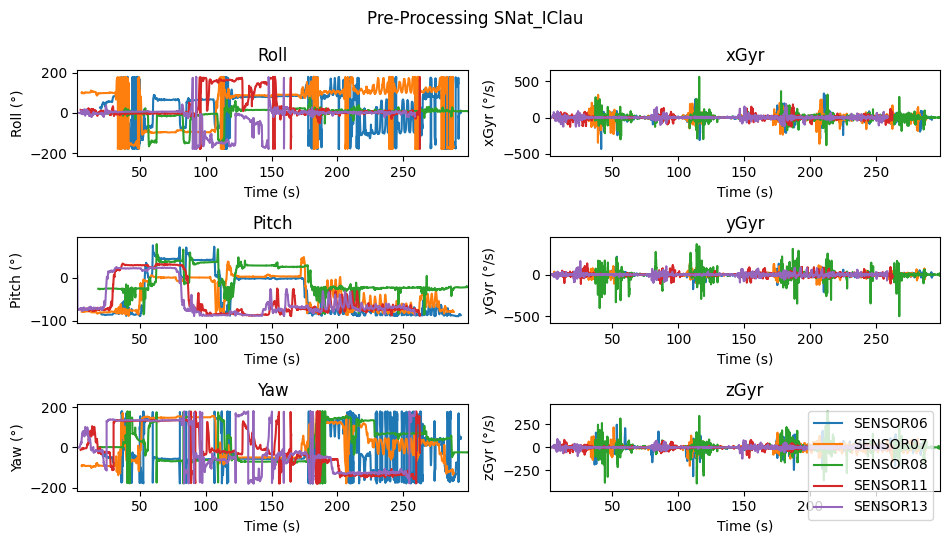

C:\Users\natis\AppData\Local\Temp\ipykernel_9384\270396773.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['TimeStamp']= time
C:\Users\natis\AppData\Local\Temp\ipykernel_9384\270396773.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var.iloc[drv[f]:drv[(f)+1]]=-(var.iloc[drv[f]:drv[(f)+1]])+chg


--- 2.3360259532928467 seconds ---


In [267]:
start_time = time.time()
#test= input('put the name test:')
# 'RotCad_p1' 2022_10_18\Dia_1\SClau_IJose
test = 'SNat_IClau'
dir= "./2022_10_18/Dia_2/"+test+'/' #"D:/_Proyecto-SAM/2022-02-01/"+test+'/'
# Load the data
data= Load_Files(dir)

# Plot the data
Plot_Data(data,test,'Pre-Processing')
# Set Start to 0 Sensors(SAM).
data= Set_Data(data)
# Plot_Data(data,test,'Setto 0')
# Adjust angles range to a continous angles.
data= Change_Range(data,150)
#Plot_Data(data,test,'Change range')
# Oversample the data to 200 Hz.
data= Resample(data,200)
#Plot_Data(data,test,'Resample')
# Synchronize the data.
data= Syncronize(data)
#Plot_Data(data, test, 'Synchronize')
# Resample the data to 50 Hz.
data= Resample(data,50)
#Plot_Data(data,test,'Resample')
# Make all the dataframes have the same size.
data= Same_size(data)
# Plot the data
#Plot_Data(data,test,'Post-Processing')

# Find Angles
# ang_hip= angles_Hip(data['SENSOR11'],data['SENSOR07'],'r')
# ang_knee= angles_Knee(data['SENSOR07'],data['SENSOR06'],'r')
# ang_ankle= angles_Ankle(data['SENSOR06'],data['SENSOR08'],'r')

print("--- %s seconds ---" % (time.time() - start_time))


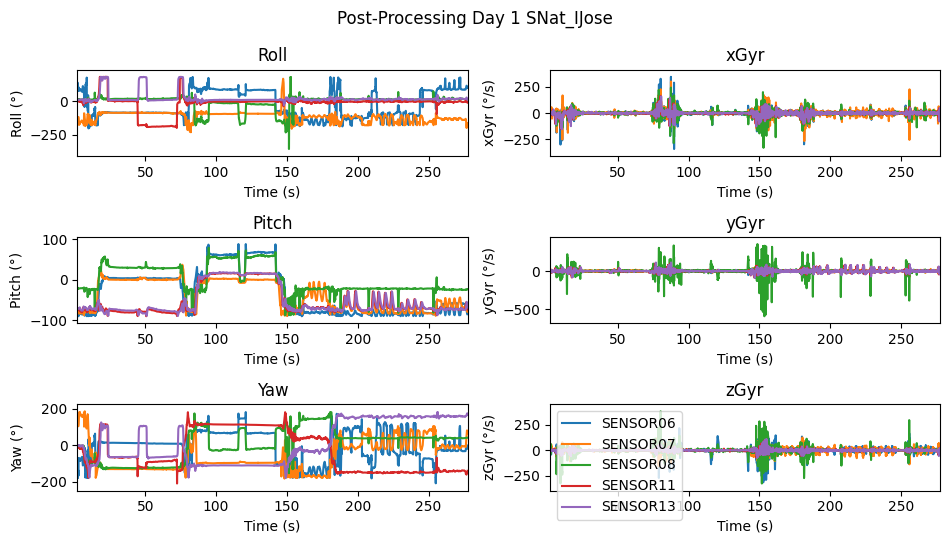

In [256]:
#Manual Sync Día1 SNat_IJose
dataManualD1_SNat_IJose= copy.deepcopy(data)
time = dataManualD1_SNat_IJose['SENSOR08']['TimeStamp']
new_time = time + 2
dataManualD1_SNat_IJose['SENSOR08']['TimeStamp'] = new_time

time2 = dataManualD1_SNat_IJose['SENSOR11']['TimeStamp']
new_time2 = time2 - 6
dataManualD1_SNat_IJose['SENSOR11']['TimeStamp'] = new_time2

time3 = dataManualD1_SNat_IJose['SENSOR07']['TimeStamp']
new_time3 = time3 - 1
dataManualD1_SNat_IJose['SENSOR07']['TimeStamp'] = new_time3

dataManualD1_SNat_IJose = Cut(dataManualD1_SNat_IJose)

dataend = 100000000
for i in dataManualD1_SNat_IJose:
  s = dataManualD1_SNat_IJose[i]
  end = len(s)
  if end <= dataend:
      dataend = end

for i in data:
  s = dataManualD1_SNat_IJose[i]
  s = s.iloc[:dataend, :]
  dataManualD1_SNat_IJose[i] = s


Plot_Data(dataManualD1_SNat_IJose, test, 'Post-Processing Day 1')


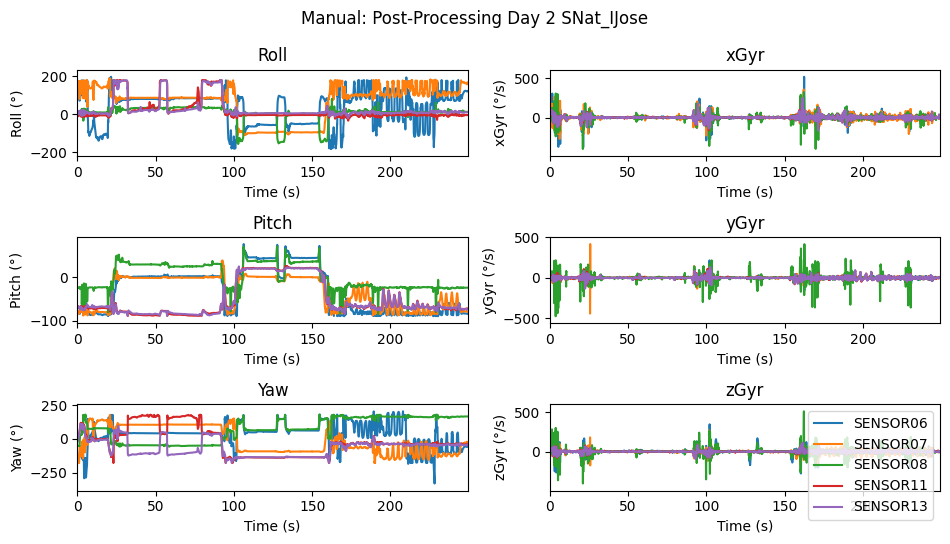

In [260]:
#Manual Sync Día2 SNat_IJose
dataManualD2_SNat_IJose = copy.deepcopy(data)
time = dataManualD2_SNat_IJose['SENSOR07']['TimeStamp']
new_time = time - 1
dataManualD2_SNat_IJose['SENSOR07']['TimeStamp'] = new_time

time2 = dataManualD2_SNat_IJose['SENSOR06']['TimeStamp']
new_time2 = time2 - 6
dataManualD2_SNat_IJose['SENSOR06']['TimeStamp'] = new_time2

time3 = dataManualD2_SNat_IJose['SENSOR08']['TimeStamp']
new_time3 = time3 - 6
dataManualD2_SNat_IJose['SENSOR08']['TimeStamp'] = new_time3

dataManualD2_SNat_IJose = Cut(dataManualD2_SNat_IJose)

dataend = 100000000
for i in dataManualD2_SNat_IJose:
  s = dataManualD2_SNat_IJose[i]
  end = len(s)
  if end <= dataend:
      dataend = end

for i in data:
  s = dataManualD2_SNat_IJose[i]
  s = s.iloc[:dataend, :]
  dataManualD2_SNat_IJose[i] = s
  
Plot_Data(dataManualD2_SNat_IJose, test, 'Manual: Post-Processing Day 2')



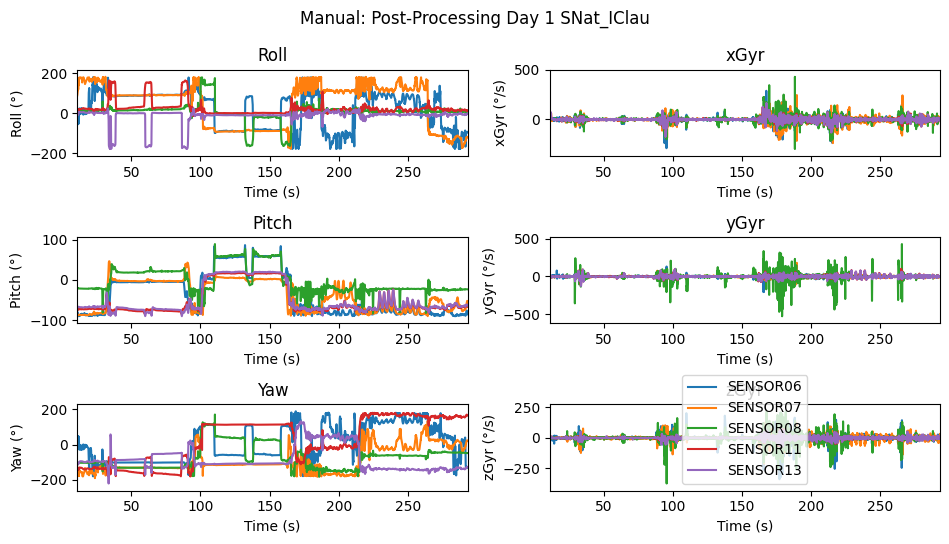

In [264]:
#Manual Sync Día1 SNat_IClau
dataManualD1_SNat_IClau = copy.deepcopy(data)
time = dataManualD1_SNat_IClau['SENSOR08']['TimeStamp']
new_time = time - 8
dataManualD1_SNat_IClau['SENSOR08']['TimeStamp'] = new_time

time2 = dataManualD1_SNat_IClau['SENSOR11']['TimeStamp']
new_time2 = time2 + 5
dataManualD1_SNat_IClau['SENSOR11']['TimeStamp'] = new_time2

time4 = dataManualD1_SNat_IClau['SENSOR13']['TimeStamp']
new_time4 = time4 + 11
dataManualD1_SNat_IClau['SENSOR13']['TimeStamp'] = new_time4

time3 = dataManualD1_SNat_IClau['SENSOR06']['TimeStamp']
new_time3 = time - 4
dataManualD1_SNat_IClau['SENSOR06']['TimeStamp'] = new_time3

dataManualD1_SNat_IClau = Cut(dataManualD1_SNat_IClau)

dataend = 100000000
for i in dataManualD1_SNat_IClau:
  s = dataManualD1_SNat_IClau[i]
  end = len(s)
  if end <= dataend:
      dataend = end

for i in data:
  s = dataManualD1_SNat_IClau[i]
  s = s.iloc[:dataend, :]
  dataManualD1_SNat_IClau[i] = s
  
Plot_Data(dataManualD1_SNat_IClau, test, 'Manual: Post-Processing Day 1')


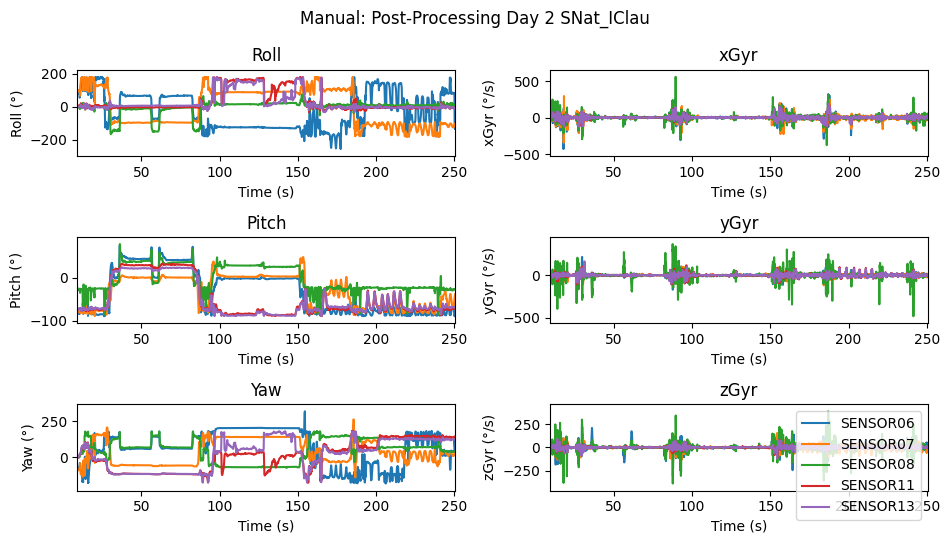

In [268]:
#Manual Sync Día2 SNat_IClau
dataManualD2_SNat_IClau = copy.deepcopy(data)
time = dataManualD2_SNat_IClau['SENSOR08']['TimeStamp']
new_time = time - 3
dataManualD2_SNat_IClau['SENSOR08']['TimeStamp'] = new_time

time2 = dataManualD2_SNat_IClau['SENSOR07']['TimeStamp']
new_time2 = time2 - 4
dataManualD2_SNat_IClau['SENSOR07']['TimeStamp'] = new_time2

time3 = dataManualD2_SNat_IClau['SENSOR11']['TimeStamp']
new_time3 = time3 + 8.5
dataManualD2_SNat_IClau['SENSOR11']['TimeStamp'] = new_time3

time4 = dataManualD2_SNat_IClau['SENSOR13']['TimeStamp']
new_time4 = time4 + 9
dataManualD2_SNat_IClau['SENSOR13']['TimeStamp'] = new_time4

dataManualD2_SNat_IClau = Cut(dataManualD2_SNat_IClau)

dataend = 100000000
for i in dataManualD2_SNat_IClau:
  s = dataManualD2_SNat_IClau[i]
  end = len(s)
  if end <= dataend:
      dataend = end

for i in data:
  s = dataManualD2_SNat_IClau[i]
  s = s.iloc[:dataend, :]
  dataManualD2_SNat_IClau[i] = s
  
Plot_Data(dataManualD2_SNat_IClau, test, 'Manual: Post-Processing Day 2')

In [269]:
Hip_D1_IJose_SNat = angles_Hip(
    dataManualD1_SNat_IJose['SENSOR11'], dataManualD1_SNat_IJose['SENSOR07'], 'l')
Knee_D1_IJose_SNat = angles_Knee(
    dataManualD1_SNat_IJose['SENSOR07'], dataManualD1_SNat_IJose['SENSOR06'], 'l')
Ankle_D1_IJose_SNat = angles_Ankle(
    dataManualD1_SNat_IJose['SENSOR06'], dataManualD1_SNat_IJose['SENSOR08'], 'l')

Hip_D2_IJose_SNat = angles_Hip(
    dataManualD2_SNat_IJose['SENSOR11'], dataManualD2_SNat_IJose['SENSOR07'], 'l')
Knee_D2_IJose_SNat = angles_Knee(
    dataManualD2_SNat_IJose['SENSOR07'], dataManualD2_SNat_IJose['SENSOR06'], 'l')
Ankle_D2_IJose_SNat = angles_Ankle(
    dataManualD2_SNat_IJose['SENSOR06'], dataManualD2_SNat_IJose['SENSOR08'], 'l')

Hip_D1_IClau_SNat = angles_Hip(
    dataManualD1_SNat_IClau['SENSOR11'], dataManualD1_SNat_IClau['SENSOR07'], 'l')
Knee_D1_IClau_SNat = angles_Knee(
    dataManualD1_SNat_IClau['SENSOR07'], dataManualD1_SNat_IClau['SENSOR06'], 'l')
Ankle_D1_IClau_SNat = angles_Ankle(
    dataManualD1_SNat_IClau['SENSOR06'], dataManualD1_SNat_IClau['SENSOR08'], 'l')

Hip_D2_IClau_SNat = angles_Hip(
    dataManualD2_SNat_IClau['SENSOR11'], dataManualD2_SNat_IClau['SENSOR07'], 'l')
Knee_D2_IClau_SNat = angles_Knee(
    dataManualD2_SNat_IClau['SENSOR07'], dataManualD2_SNat_IClau['SENSOR06'], 'l')
Ankle_D2_IClau_SNat = angles_Ankle(
    dataManualD2_SNat_IClau['SENSOR06'], dataManualD2_SNat_IClau['SENSOR08'], 'l')


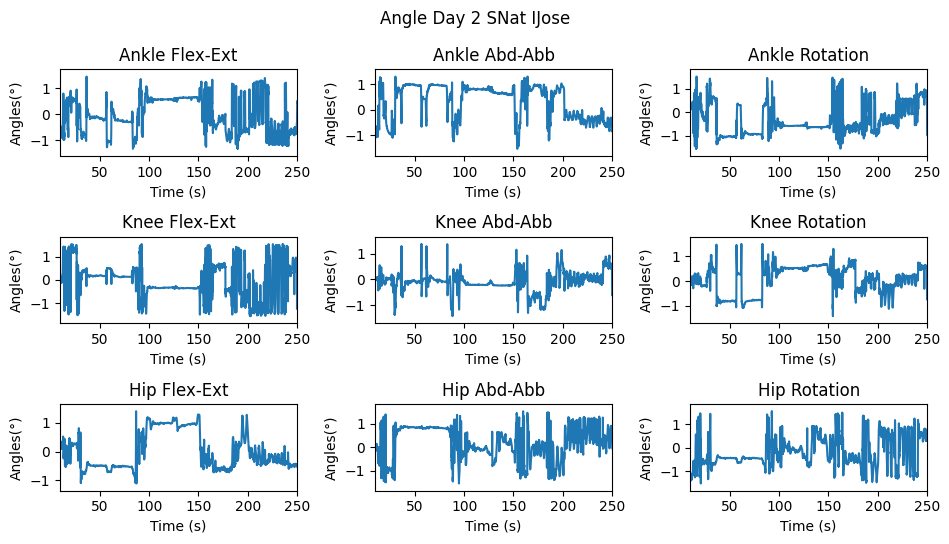

In [291]:
from matplotlib.pyplot import show, subplots
time = dataManualD2_SNat_IClau['SENSOR08']['TimeStamp']
Plot_Ang('Day 2 SNat IJose', time, Ankle_D2_IClau_SNat, Knee_D2_IClau_SNat, Hip_D2_IClau_SNat)


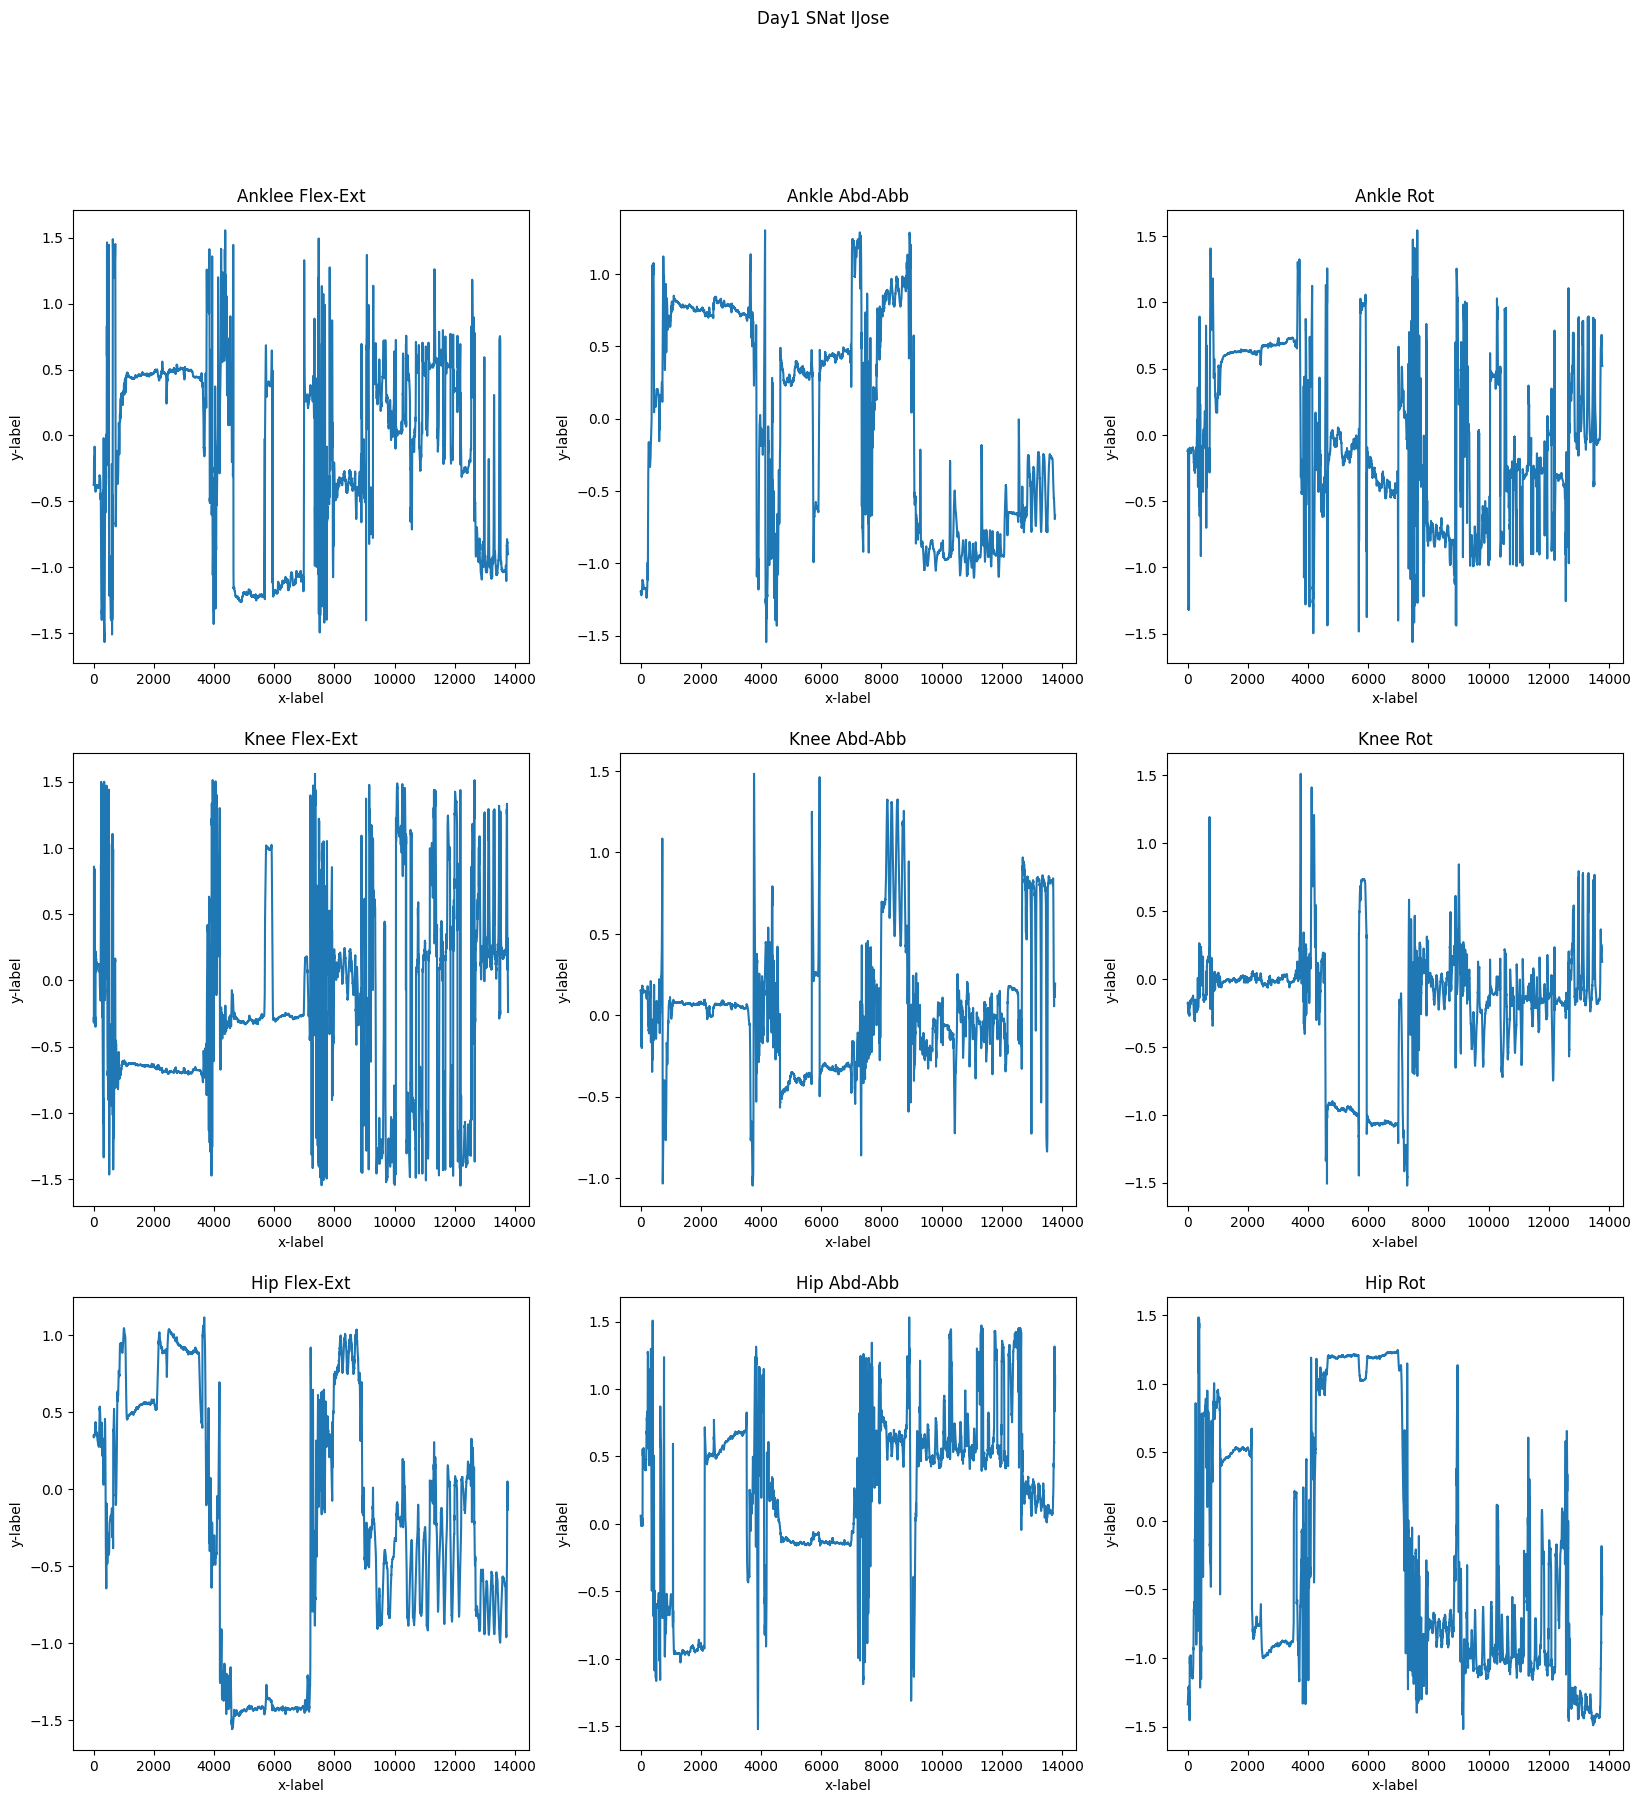

In [283]:
fig, axs = plt.subplots(3, 3)
fig.suptitle('Day1 SNat IJose')
axs[0, 0].plot(Ankle_D1_IJose_SNat.index, Ankle_D1_IJose_SNat["Fle_Ext"])
axs[0, 0].set_title('Anklee Flex-Ext')
axs[0, 1].plot(Ankle_D1_IJose_SNat.index, Ankle_D1_IJose_SNat["Abd_Abb"])
axs[0, 1].set_title('Ankle Abd-Abb')
axs[0, 2].plot(Ankle_D1_IJose_SNat.index, Ankle_D1_IJose_SNat["Rot"])
axs[0, 2].set_title('Ankle Rot')
axs[1, 0].plot(Ankle_D1_IJose_SNat.index, Knee_D1_IJose_SNat["Fle_Ext"])
axs[1, 0].set_title('Knee Flex-Ext')
axs[1, 1].plot(Ankle_D1_IJose_SNat.index, Knee_D1_IJose_SNat["Abd_Abb"])
axs[1, 1].set_title('Knee Abd-Abb')
axs[1, 2].plot(Ankle_D1_IJose_SNat.index, Knee_D1_IJose_SNat["Rot"])
axs[1, 2].set_title('Knee Rot')
axs[2, 0].plot(Ankle_D1_IJose_SNat.index, Hip_D1_IJose_SNat["Fle_Ext"])
axs[2, 0].set_title('Hip Flex-Ext')
axs[2, 1].plot(Ankle_D1_IJose_SNat.index, Hip_D1_IJose_SNat["Abd_Abb"])
axs[2, 1].set_title('Hip Abd-Abb')
axs[2, 2].plot(Ankle_D1_IJose_SNat.index, Hip_D1_IJose_SNat["Rot"])
axs[2, 2].set_title('Hip Rot')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

fig.set_figwidth(20)
fig.set_figheight(20)